In [224]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB

device = torch.device('cpu')

In [228]:
RANDOM_STATE = 3
ALPHA = 0.5
COLOR = {
    0: (1.0,0.0,0.0,ALPHA),
    1: (1.0,1.0,0.0,ALPHA),
    2: (0.0,1.0,0.0,ALPHA)
}
LABELS = {
    0: 'low',
    1: 'med',
    2: 'high'
}

# Part 1: Load dataset

In [4]:
COLUMNS = ['Thermal', 'Area', 'Glazing', 'Clading', 'Roofing', 'Efficiency']
DATA_PATH = "../data/A4.csv"

In [229]:
dataset = pd.read_csv(
    DATA_PATH,
    header=None,
    )
dataset.columns = COLUMNS
dataset

,Thermal,Area,Glazing,Clading,Roofing,Efficiency
0,0.478906,-0.325715,-0.201680,1.377879,-0.790187,1.0
1,0.887745,-0.982655,-0.755880,-0.077044,2.386029,0.0
2,0.581782,1.411420,-0.337430,0.283691,0.951966,0.0
3,0.831987,0.366473,-0.866091,1.245959,0.698279,0.0
4,1.613315,0.338684,-0.102595,2.280645,-0.237227,1.0
...,...,...,...,...,...,...
295,0.810276,-0.141231,-1.052647,0.733638,1.538608,0.0
296,1.647412,-0.898578,0.504574,1.056802,0.729426,2.0
297,-2.000397,-0.236911,-2.138618,-0.511405,-0.179371,1.0
298,-0.943171,0.811182,-1.812396,-0.624021,1.314708,2.0


In [230]:
dataset.describe()

,Thermal,Area,Glazing,Clading,Roofing,Efficiency
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.128265,-0.002983,-0.316095,0.048268,0.499361,0.533333
std,1.503949,1.053598,1.326535,1.495772,1.389207,0.695582
min,-3.219658,-2.884776,-4.725889,-5.275382,-2.771079,0.000000
25%,-0.905918,-0.751516,-1.214255,-1.043870,-0.598730,0.000000
50%,0.313206,-0.015537,-0.564895,-0.084569,0.537263,0.000000
75%,1.109229,0.706645,0.610301,1.202053,1.474921,1.000000
max,5.921850,3.371275,4.156128,4.185175,4.167041,2.000000


# Part 2: Stratified Sampling

In [231]:
TRAIN_SIZE = 0.75

In [232]:
labels = dataset[COLUMNS[-1]]

In [233]:
train_dataset, test_dataset = train_test_split(
    dataset,
    train_size=TRAIN_SIZE, 
    stratify=labels, 
    random_state=RANDOM_STATE
)

In [234]:
train_dataset['Efficiency'].value_counts()

Efficiency
0.0    131
1.0     68
2.0     26
Name: count, dtype: int64

In [235]:
test_dataset['Efficiency'].value_counts()

Efficiency
0.0    44
1.0    22
2.0     9
Name: count, dtype: int64

In [236]:
dataset['Efficiency'].value_counts()

Efficiency
0.0    175
1.0     90
2.0     35
Name: count, dtype: int64

# Part 3: Visulization

In [13]:
BINS_COUNT = 30

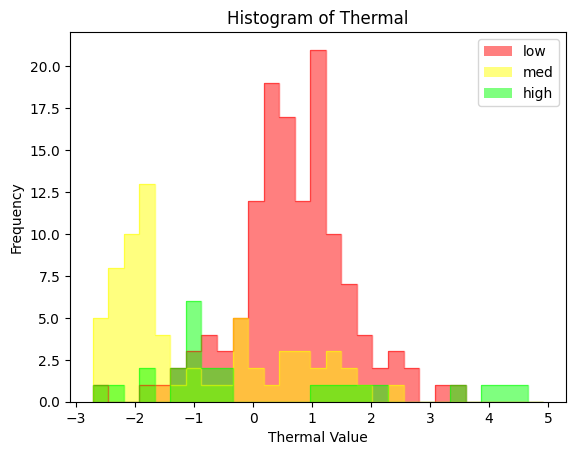

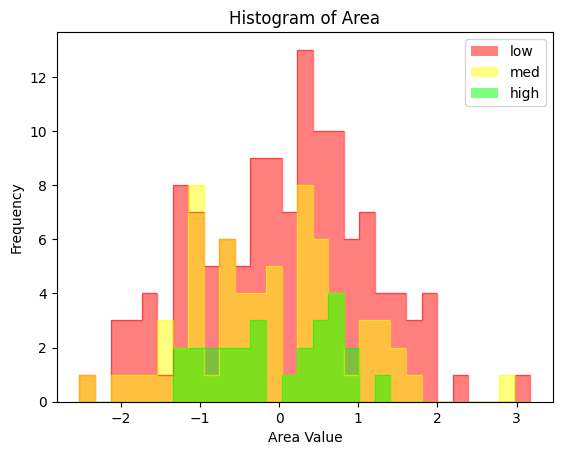

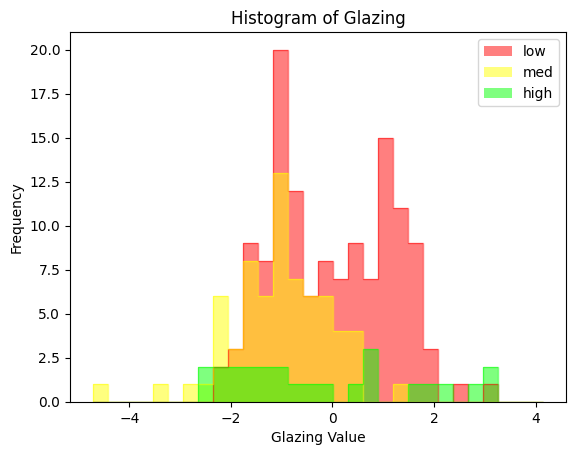

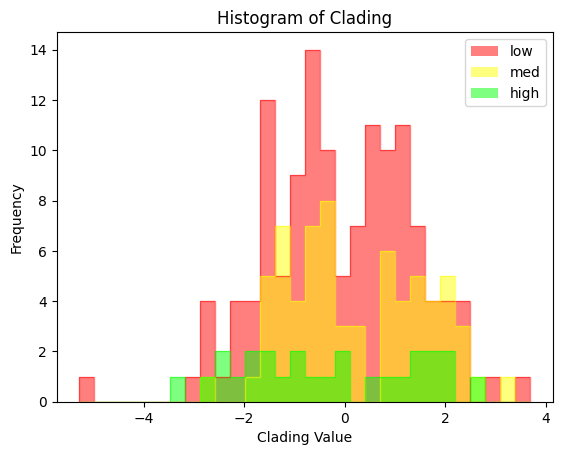

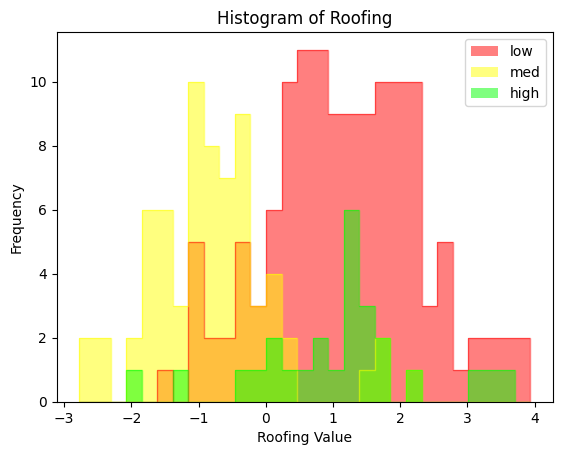

In [14]:
for column in COLUMNS[:-1]:
    data_df = train_dataset[[column,COLUMNS[-1]]]
    max_value = data_df[column].max()
    min_value = data_df[column].min()
    step = (max_value - min_value) / BINS_COUNT
    range_ = np.arange(min_value, max_value, step)
    for effic in range(3):
        eff_df = data_df[data_df[COLUMNS[-1]] == effic]
        eff_df[column].plot.hist(
            bins=range_,
            histtype=u'step',
            color=COLOR[effic],
        )
        ax = eff_df[column].plot.hist(
            bins=range_,
            color=COLOR[effic],
            label=LABELS[effic],
            legend=True
        )
    plt.title(f"Histogram of {column}")
    plt.xlabel(f"{column} Value")
    plt.show()
    # break

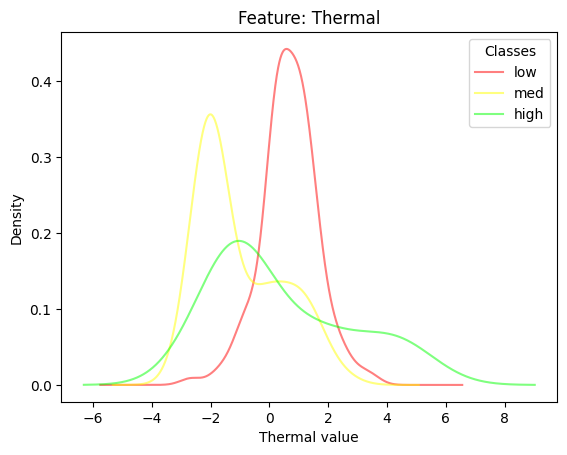

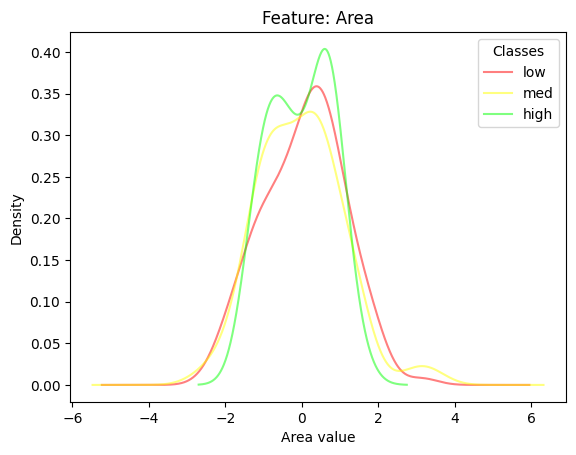

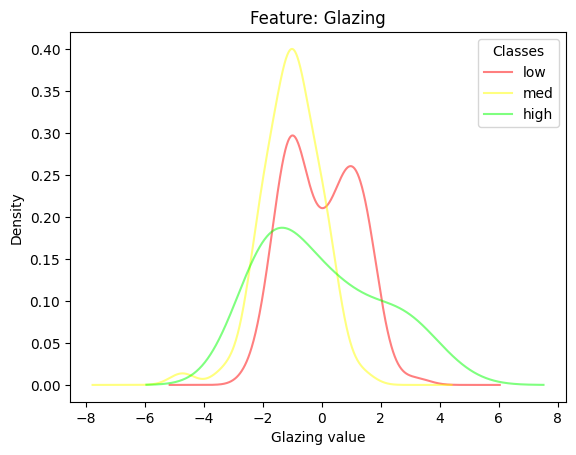

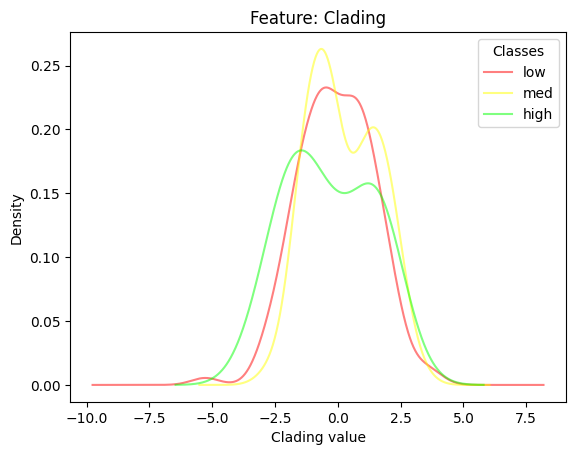

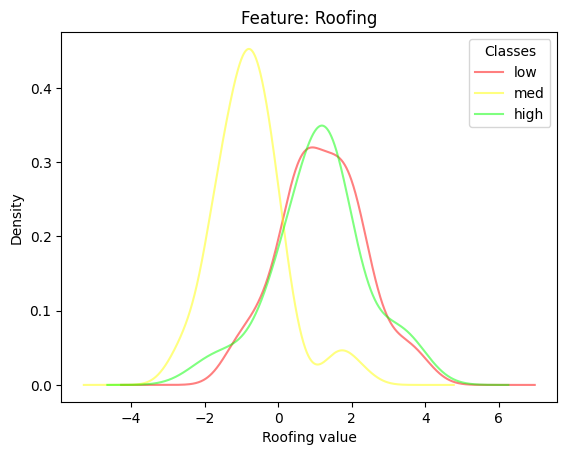

In [15]:
densities = {}

for feature in COLUMNS[:-1]:
    ax = train_dataset[train_dataset[COLUMNS[-1]] == 0][[feature]].plot.density(label=LABELS[0], color=COLOR[0], title=f"Feature: {feature}", xlabel="{feature}")
    train_dataset[train_dataset[COLUMNS[-1]] == 1][[feature]].plot.density(ax=ax, label=LABELS[1], color=COLOR[1], xlabel="{feature}")
    train_dataset[train_dataset[COLUMNS[-1]] == 2][[feature]].plot.density(ax=ax, label=LABELS[2], color=COLOR[2], xlabel="{feature}")
    ax.legend(LABELS.values(), title="Classes")
    ax.set_xlabel(f"{feature} value")

    densities[feature] = ax

### Which  feature  looks  most  useful  and  why?
Sol: Thermal

### Which  home  efficiency  class  do  you  think  will have the lowest accuracy and why?
Sol: high

# Part 4: Cross Validation

In [16]:
kernal_type = 'poly'
degree = 3
c = 0.8
folds = 5

In [17]:
x = train_dataset[COLUMNS[:-1]]
y = train_dataset[COLUMNS[-1]]

In [18]:
svc = SVC(kernel=kernal_type, degree=degree, C=c)

In [48]:
cross_validation = KFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)
cross_validation_stratified = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE) 

print("Non-Stratified CV")
cross_validation_score = cross_val_score(svc, x, y, cv=cross_validation)
for i, score in enumerate(cross_validation_score):
    print(f'Fold {i}: Accuracy = {score:.5f}')
avg_acc = np.mean(cross_validation_score)
std_acc = np.std(cross_validation_score)
print(f'Average Accuracy: {avg_acc:.4f}')
print(f'Standard Deviation: {std_acc:.4f}')

print("\n\nStratified CV")
cross_validation_stratified_score = cross_val_score(svc, x, y, cv=cross_validation_stratified)
for i, score in enumerate(cross_validation_stratified_score):
    print(f'Fold {i}: Accuracy = {score:.5f}')
avg_acc_stratified = np.mean(cross_validation_stratified_score)
std_acc_stratified = np.std(cross_validation_stratified_score)
print(f'Average Accuracy: {avg_acc_stratified:.4f}')
print(f'Standard Deviation: {std_acc_stratified:.4f}')


Non-Stratified CV
Fold 0: Accuracy = 0.75556
Fold 1: Accuracy = 0.82222
Fold 2: Accuracy = 0.80000
Fold 3: Accuracy = 0.77778
Fold 4: Accuracy = 0.82222
Average Accuracy: 0.7956
Standard Deviation: 0.0259


Stratified CV
Fold 0: Accuracy = 0.75556
Fold 1: Accuracy = 0.75556
Fold 2: Accuracy = 0.73333
Fold 3: Accuracy = 0.88889
Fold 4: Accuracy = 0.84444
Average Accuracy: 0.7956
Standard Deviation: 0.0603


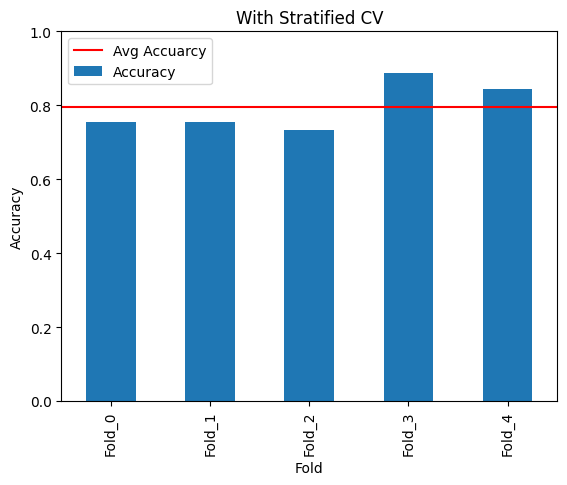

In [50]:
accuracy_df = pd.DataFrame(cross_validation_stratified_score)
accuracy_df.columns = ["Accuracy"]
accuracy_df.index = [f"Fold_{index}" for index in range(5)]
accuracy_df.plot(
    kind='bar',
    label=["Accuracy"],
    legend=False,
    ylim=(0,1),
    xlabel="Fold",
    ylabel="Accuracy",
    title="With Stratified CV"
)
plt.plot([-10,10],[avg_acc,avg_acc], color='red', label="Avg Accuarcy")
plt.legend()

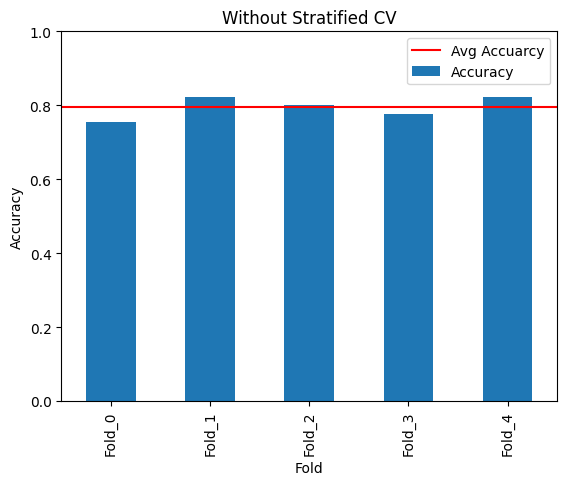

In [49]:
accuracy_df = pd.DataFrame(cross_validation_score)
accuracy_df.columns = ["Accuracy"]
accuracy_df.index = [f"Fold_{index}" for index in range(5)]
accuracy_df.plot(
    kind='bar',
    label=["Accuracy"],
    legend=False,
    ylim=(0,1),
    xlabel="Fold",
    ylabel="Accuracy",
    title="Without Stratified CV"
)
plt.plot([-10,10],[avg_acc,avg_acc], color='red', label="Avg Accuarcy")
plt.legend()

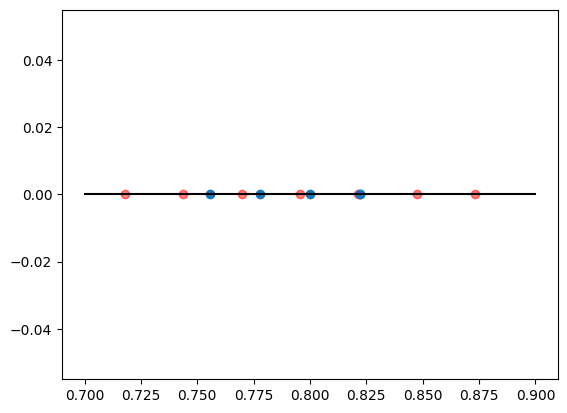

In [21]:
# # plot y axis
# plt.plot(
#     [avg_acc,avg_acc],
#     [-0.02,0.02],
#     color='black'
# )

# plot x axis
plt.plot(
    [0.7,0.9],
    [0,0],
    color='black'
)

# plot std
plt.scatter(
    [avg_acc-(index*std_acc) for index in range(-3,4,1)],
    [0 for _ in range(-3,4,1)],
    color=(1,0,0,0.5)
)

# plot accuracy
plt.scatter(
    [acc for acc in cross_validation_score],
    [0 for _ in cross_validation_score],
)


# Part 5: Without Cross Validation

In [22]:
svc.fit(train_dataset[COLUMNS[:-1]], train_dataset[COLUMNS[-1]])

SVC(C=0.8, kernel='poly')

In [23]:
svc_score = svc.score(test_dataset[COLUMNS[:-1]], test_dataset[COLUMNS[-1]])
svc_score

0.7866666666666666

In [24]:
y_pred = svc.predict(test_dataset[COLUMNS[:-1]])
print(classification_report(test_dataset[COLUMNS[-1]], y_pred))

              precision    recall  f1-score   support

         0.0       0.73      1.00      0.85        44
         1.0       1.00      0.59      0.74        22
         2.0       1.00      0.22      0.36         9

    accuracy                           0.79        75
   macro avg       0.91      0.60      0.65        75
weighted avg       0.84      0.79      0.76        75



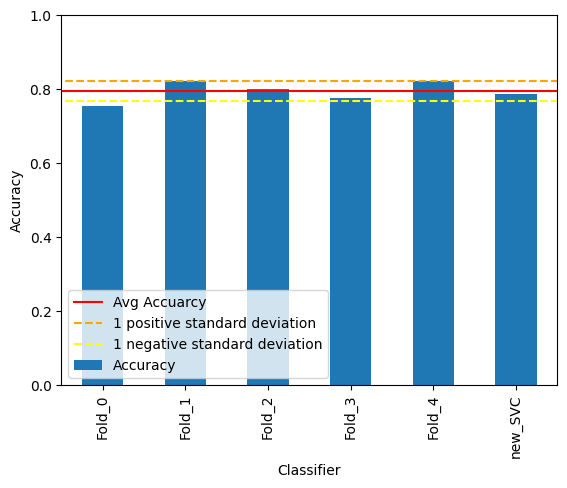

In [25]:
accuracy_df = pd.DataFrame(list(cross_validation_score) + [svc_score])
accuracy_df.columns = ["Accuracy"]
accuracy_df.index = [f"Fold_{index}" for index in range(5)] + ["new_SVC"]
accuracy_df.plot(
    kind='bar',
    label=["Accuracy"],
    legend=False,
    ylim=(0,1),
    xlabel="Classifier",
    ylabel="Accuracy"
)
plt.plot([-10,10],[avg_acc,avg_acc], color='red', label="Avg Accuarcy")
plt.plot([-10,10],[avg_acc+std_acc,avg_acc+std_acc], color='orange', label="1 positive standard deviation", linestyle="--")
plt.plot([-10,10],[avg_acc-std_acc,avg_acc-std_acc], color='yellow', label="1 negative standard deviation", linestyle="--")
plt.legend()

# Part 6: Misclassification Cost

In [26]:
cost = np.array([
    [0,1,2],
    [1,0,1],
    [2,1,0]
])

In [27]:
confusion = confusion_matrix(test_dataset[COLUMNS[-1]], y_pred)
confusion

array([[44,  0,  0],
       [ 9, 13,  0],
       [ 7,  0,  2]])

In [28]:
np.trace(np.dot(confusion , cost))

23

# Part 7: Neural Network

In [105]:
num_hidden = [1,  10,  100]
folds = 5
epochs = 2000
learning_rate = 0.001

models = {}
losses = {}
accuracy = {}

In [106]:
class HouseEfficNN(torch.nn.Module):
    def __init__(self, hidden_size):
        super(HouseEfficNN, self).__init__()
        self.input_size = 5
        self.output_size = 3
        self.hidden_size = hidden_size

        self.layer_1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.activation = torch.nn.Tanh()
        self.layer_2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.output = torch.nn.Softmax(1)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.activation(x)
        x = self.layer_2(x)
        x = self.output(x)
        return x

In [107]:
class HousingDataset(torch.utils.data.Dataset):
    def __init__(self, df, target_column):
        self.features = torch.tensor(df.drop(columns=[target_column]).values, dtype=torch.float32)
        self.labels = torch.tensor(df[target_column].values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [221]:
for h_num in num_hidden:
    losses[h_num] = {}
    accuracy[h_num] = {}
    cross_fold_NN = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)
    
    for fold_index, (train_index, test_index) in enumerate(cross_fold_NN.split(train_dataset[COLUMNS[:-1]], train_dataset[COLUMNS[-1:]])):
        fold_nn_train_df = train_dataset.iloc[train_index]
        fold_nn_train_features, fold_nn_train_labels = HousingDataset(fold_nn_train_df, COLUMNS[-1])[:]
        
        fold_nn_test_df = train_dataset.iloc[test_index]
        fold_nn_test_features, fold_nn_test_labels = HousingDataset(fold_nn_test_df, COLUMNS[-1])[:]

        model = HouseEfficNN(hidden_size=h_num)

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = torch.nn.CrossEntropyLoss()

        losses[h_num][fold_index] = []
        accuracy[h_num][fold_index] = []
        
        for epoch in tqdm(range(epochs), desc=f"H_size: {h_num}, Fold: {fold_index}", unit='epoch',):
            model.train()
            optimizer.zero_grad()
            outputs = model(fold_nn_train_features)
            loss = criterion(outputs, fold_nn_train_labels)
            loss.backward()
            optimizer.step()

            losses[h_num][fold_index].append(loss.item())

            model.eval()
            predictions = model(fold_nn_test_features)
            acc = accuracy_score(fold_nn_test_labels, predictions.argmax(1).detach().numpy())
            accuracy[h_num][fold_index].append(acc)
            
        models[h_num] = model

H_size: 100, Fold: 4: 100%|██████████| 2000/2000 [00:01<00:00, 1042.05epoch/s]


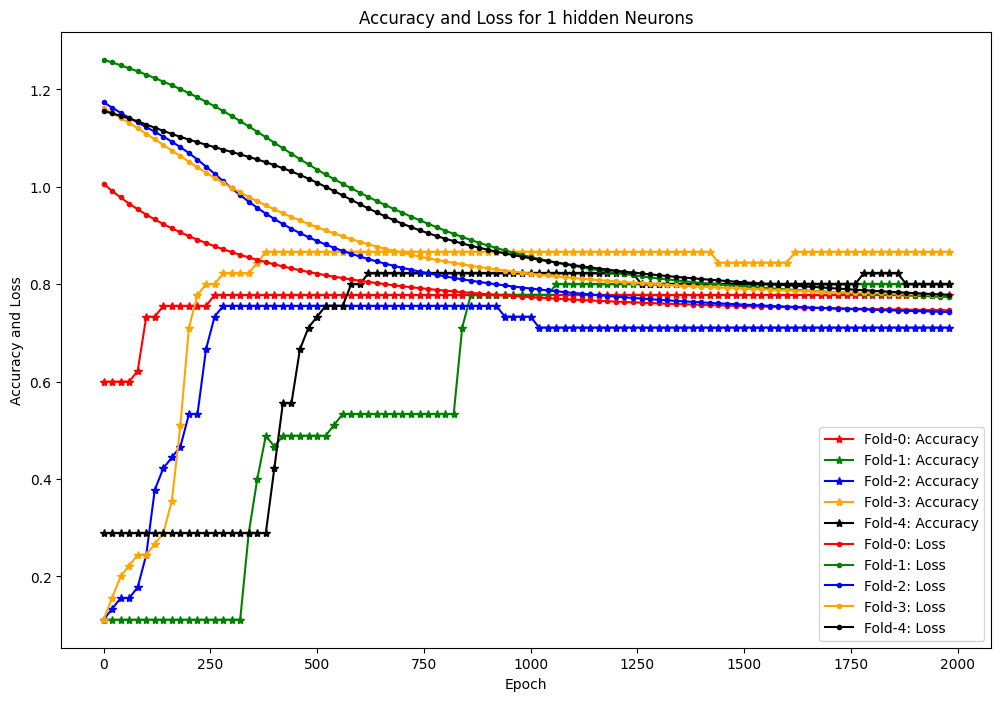

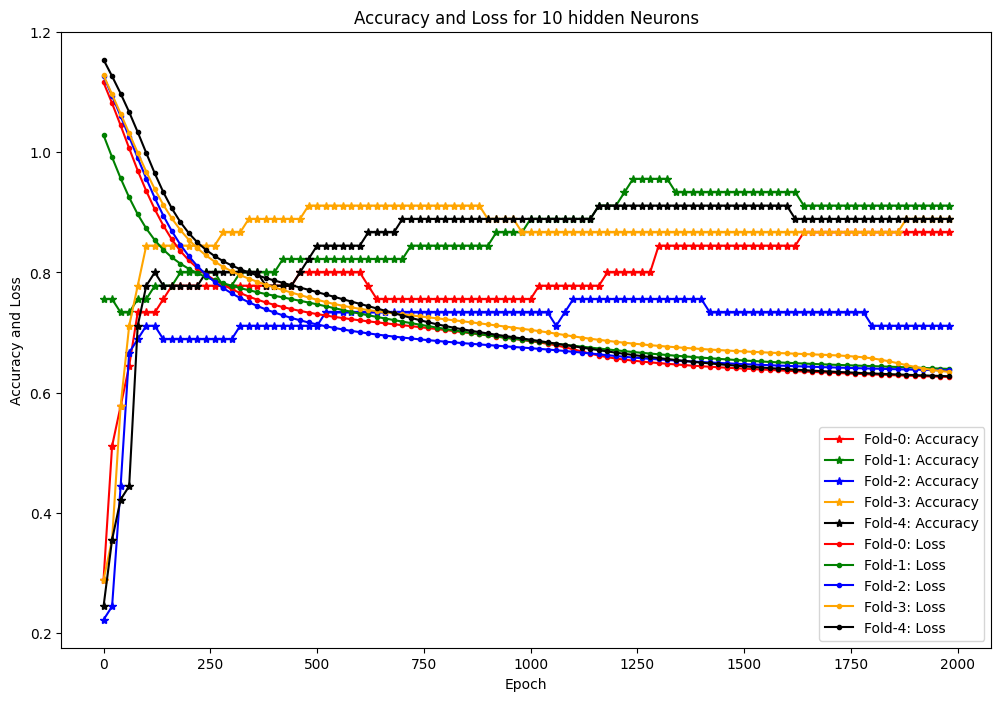

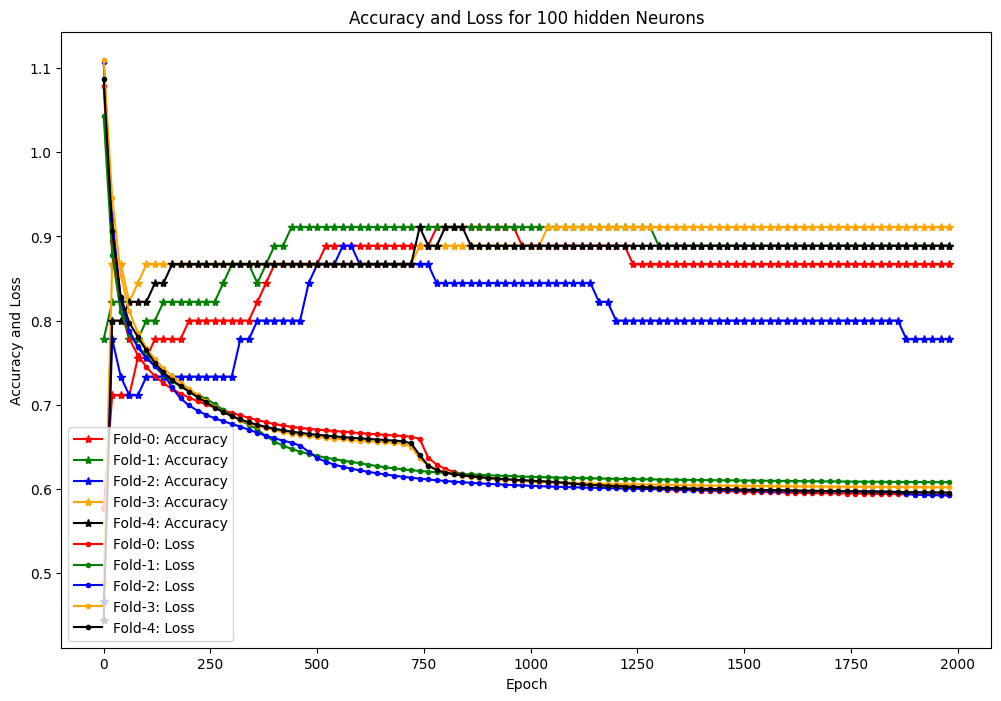

In [222]:
for h_num in num_hidden:
    ax = pd.DataFrame(accuracy[h_num])[::20].plot(
        figsize=(12,8),
        xlabel="Epoch",
        ylabel="Accuracy and Loss",
        marker="*",
        title=f"Accuracy and Loss for {h_num} hidden Neurons",
        color=['red','green','blue','orange','black']
    )
    pd.DataFrame(losses[h_num])[::20].plot(
        ax = ax,
        xlabel="Epoch",
        # ylabel="Loss",
        marker=".",
        # title=f"Loss for {h_num} hidden Neurons",
        color=['red','green','blue','orange','black'],
    )
    plt.legend([f"Fold-{f}: Accuracy" for f in range(folds)]+[f"Fold-{f}: Loss" for f in range(folds)])


In [223]:
nn_accuracy_df = pd.DataFrame(
    {
        f: [accuracy[num_neurons][f][-1] for num_neurons in num_hidden]
        for f in range(folds)
    },
    index=num_hidden)

nn_accuracy_df["mean"] = nn_accuracy_df.mean(axis=1)
nn_accuracy_df["std"] = nn_accuracy_df.std(axis=1)

nn_accuracy_df

,0,1,2,3,4,mean,std
1,0.777778,0.800000,0.711111,0.866667,0.800000,0.791111,0.049889
10,0.866667,0.911111,0.711111,0.888889,0.888889,0.853333,0.072487
100,0.866667,0.888889,0.777778,0.911111,0.888889,0.866667,0.046614


# Part 8: Naive Bayes Classifier

In [188]:
# init
num_iters = 9999

accuracies_5_features = []
accuracies_1_features = []
accuracies_diff = []

In [226]:
# calculate the diffrence of accuracies for the two models
real_classifier_5 = GaussianNB()
real_classifier_5.fit(train_dataset[COLUMNS[:-1]], train_dataset[COLUMNS[-1]])
y_pred_real_5 = real_classifier_5.predict(test_dataset[COLUMNS[:-1]])
accuracy_5 = accuracy_score(test_dataset[COLUMNS[-1]], y_pred_real_5)

real_classifier_1 = GaussianNB()
real_classifier_1.fit(train_dataset[[COLUMNS[0]]], train_dataset[COLUMNS[-1]])
y_pred_real_1 = real_classifier_1.predict(test_dataset[[COLUMNS[0]]])
accuracy_1 = accuracy_score(test_dataset[COLUMNS[-1]], y_pred_real_1)

real_diff = accuracy_1 - accuracy_5
print(f"1 feature: {accuracy_1}")
print(f"5 feature: {accuracy_5}")

1 feature: 0.76
5 feature: 0.76


In [227]:
gnb = GaussianNB()
for _ in range(num_iters):
    iter_train_df = train_dataset.sample(
        len(train_dataset),
        replace = True
    )

    iter_test_df = test_dataset.sample(
        len(test_dataset),
        replace = True
    )

    gnb.fit(iter_train_df[COLUMNS[:-1]], iter_train_df[COLUMNS[-1]])
    y_pred_5 = gnb.predict(iter_test_df[COLUMNS[:-1]])
    accuracy_5 = accuracy_score(iter_test_df[COLUMNS[-1]], y_pred_5)
    accuracies_5_features.append(accuracy_5)

    # nb_classifier_1 = GaussianNB()
    gnb.fit(iter_train_df[[COLUMNS[0]]], iter_train_df[COLUMNS[-1]])
    y_pred_1 = gnb.predict(iter_test_df[[COLUMNS[0]]])
    accuracy_1 = accuracy_score(iter_test_df[COLUMNS[-1]], y_pred_1)
    accuracies_1_features.append(accuracy_1)

    diff_accuracy = accuracy_1 - accuracy_5
    accuracies_diff.append(diff_accuracy)


In [245]:
observed_difference = np.mean(accuracies_1_features) - np.mean(accuracies_5_features)
combined_accuracies = np.concatenate([accuracies_1_features, accuracies_5_features])
np.random.seed(RANDOM_STATE)  # For reproducibility
permuted_differences = []

for _ in range(num_iters):
    permuted_accuracies = np.random.permutation(combined_accuracies)
    permuted_difference = np.mean(permuted_accuracies[:len(accuracies_1_features)]) - np.mean(permuted_accuracies[len(accuracies_5_features):])
    permuted_differences.append(permuted_difference)

p_value = (np.abs(permuted_differences) >= np.abs(observed_difference)).mean()
p_value

0.0

<Axes: title={'center': 'Mean under H0 for 2 classifiers'}, xlabel='accuracy', ylabel='Frequency'>

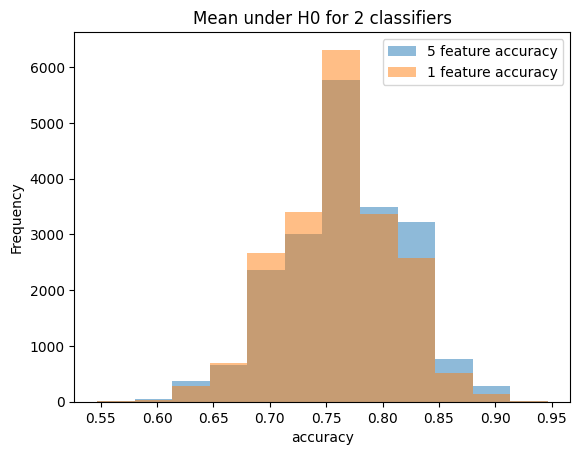

In [247]:
pd.DataFrame({
    "5 feature accuracy":accuracies_5_features,
    "1 feature accuracy": accuracies_1_features,
    # "diffrence accuracy": accuracies_diff
    }).plot.hist(bins=12, alpha=0.5, xlabel="accuracy", title="Mean under H0 for 2 classifiers")

In [238]:
sum([diff >= real_diff for diff in accuracies_diff])/num_iters

1.0145014501450145